# Statistical analysis to get the significantly associated tokens for attribution score groupings for ECOLI cohort

## Read mapping information

In [1]:
import os

import pandas as pd


demoTrainDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240614/data/wb_365_wa_1/splits_v1/demographics/mortality_normal_train.csv', sep='\t')
demoTestDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240614/data/wb_365_wa_1/splits_v1/demographics/mortality_normal_test.csv', sep='\t')
demoValidateDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240614/data/wb_365_wa_1/splits_v1/demographics/mortality_normal_validate.csv', sep='\t')
demoDf = pd.concat([demoTrainDf, demoTestDf, demoValidateDf], ignore_index=True)
demoDf

,person_id,visit_occurrence_id,TYPE,COUNTRY_OF_BIRTH,SEX,Age_Bin,JOURNEY_ID
0,678487,3312694,Emergency,Australia,Male,"(60, 70]",3312694
1,2094045,9199249,Emergency,Australia,Male,"(20, 30]",9199249
2,2107813,9410987,Emergency,Australia,Male,"(50, 60]",9410987
3,2083212,602890,Inpatient,Australia,Female,"(40, 50]",9039437
4,2083212,9039437,Emergency,Australia,Female,"(40, 50]",9039437
...,...,...,...,...,...,...,...
7194,2603535,16588204,Inpatient,Australia,Male,"(60, 70]",16588204
7195,2603535,16709341,Inpatient,Australia,Male,"(60, 70]",16709341
7196,2603535,16651755,Inpatient,Australia,Male,"(60, 70]",16651755
7197,2098616,16872774,Emergency,Australia,Female,"(80, 90]",16872774


In [2]:
import os

mappingDf = pd.read_csv(os.environ['GENOMICS_DATA_BASE'] + '/patient_tube_id_mapping_full.tsv', sep='\t')
mappingDf

,tube_code,PATIENT_ID,db_ID,pt_age,pt_gender,EPISODE_ID,hospital_admission,hospital_discharge,hospital_in_last_year,genome_species,species_reported,contig_number,length,tube_code_duplicate_or_old,date_of_collection,ID_number,location_additional_02,collected_from_original
0,AH19J072,213972.0,3JNQS,64,Male,12931474.0,2019-10-17,2019-11-29,yes,Escherichia coli,Escherichia coli,92,5131021,NaN,2019-10-30,19-303-0997,A-7EA;HAEM,Blood
1,AH19J074,213972.0,3JNQS,64,Male,12931474.0,2019-10-17,2019-11-29,yes,Streptococcus sp. D19,Streptococcus mitis group,84,2022991,NaN,2019-10-30,19-303-1174,A-7EA;HAEM,Blood Peripheral
2,AH19B003,526238.0,567AE,85,Male,640261.0,2019-02-04,2019-02-07,no,Escherichia coli,Escherichia coli,93,4942915,NaN,2019-02-03,19-034-1596,A-4WB;GMC,Blood
3,AH20A024,788941.0,3YBDS,58,Female,13194824.0,2020-01-16,2020-01-19,no,Escherichia coli,Escherichia coli,110,5149157,NaN,2020-01-16,20-016-2112,S-ED;Emergency,Blood Venous
4,AH20L041,1023735.0,2VJ78,42,Male,14210147.0,2020-12-18,2021-01-05,yes,Staphylococcus aureus,Staphylococcus aureus,46,2735216,NaN,2020-12-16,20-351-2856,Emergency Dept;nan,Blood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3112,ALF22L076,639020.0,3S6HL,84,Male,17219899.0,2022-12-15,2022-12-20,yes,Streptococcus vestibularis,Streptococcus salivarius group,107,1938627,NaN,2022-12-15,22-349-2150,Ward 4WB,Blood Peripheral
3113,ALF22L089,655404.0,6EWBM,67,Female,NaN,NaN,NaN,NaN,Proteus columbae,Proteus vulgaris,152,3972219,NaN,2022-12-17,22-351-1465,Comm/Amb Clinic,Blood
3114,ALF22L138,2572048.0,YM5PJ,61,Male,NaN,NaN,NaN,NaN,Enterobacter roggenkampii,Enterobacter cloacae complex,66,4876179,NaN,2022-12-27,22-361-0202,Ward 7 East,Hick White Lum
3115,ALF23A102,2054964.0,5DYAH,35,Female,17294287.0,2023-01-12,2023-02-01,yes,Streptococcus constellatus,Streptococcus anginosus group,54,1869828,NaN,2023-01-11,23-011-3305,ICU,Blood Venous


In [3]:
mappedJourneyTubeIdsDf = mappingDf[['tube_code', 'PATIENT_ID', 'EPISODE_ID']].drop_duplicates().merge(
    demoDf[['person_id', 'visit_occurrence_id', 'JOURNEY_ID']],
    how='inner',
    left_on=['PATIENT_ID', 'EPISODE_ID'],
    right_on=['person_id', 'visit_occurrence_id']
).drop(
    columns=['PATIENT_ID', 'EPISODE_ID', 'visit_occurrence_id']
)[['person_id', 'JOURNEY_ID', 'tube_code']].drop_duplicates()
mappedJourneyTubeIdsDf

,person_id,JOURNEY_ID,tube_code
0,50056,13224842,AH20B011
1,62567,12645629,AH19G065
2,138108,14737781,AH21E052
3,211314,13955099,AH20J009
4,211314,13955099,KPN2214
...,...,...,...
512,2084373,16158768,ALF22C004
513,1058066,16759482,ALF22H089
514,2552781,16966609,ALF22J054
515,2638484,16969999,ALF22K143


## Read bed files containing overlapping tokens and attribution scores

In [4]:
import os
import pandas as pd
from pathlib import Path


overlappingFilesDir = Path(os.environ['GENOMICS_DATA_BASE'], 'genome_nlp_tokens', 'overlapping_with_annotations', 'ECOLI')

overlappingDfList = []
for overlappingFile in os.listdir(overlappingFilesDir):
    df = pd.read_csv(Path(overlappingFilesDir, overlappingFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'feature_type', 'id', 'name', 'gene', 'atributes'])
    df['tube_code'] = [overlappingFile.split('_')[0]]*df.shape[0]
    overlappingDfList.append(df)
overlappingDf = pd.concat(overlappingDfList, ignore_index=True)
overlappingDf = overlappingDf.merge(
    mappedJourneyTubeIdsDf,
    how='inner',
    on=['tube_code']
)
overlappingDf = overlappingDf.drop_duplicates()
overlappingDf = overlappingDf[overlappingDf.tokens.apply(lambda x: (len(x) >= 5))].reset_index()
overlappingDf['gene'] = overlappingDf.gene.str.lower()
# overlappingDf = overlappingDf[overlappingDf.feature_type.isin(['CDS', 'ncRNA', 'oriC', 'regulatory_region', 'oriT'])]
overlappingDf

,index,contig_id,start_position,end_position,tokens,score,feature_type,id,name,gene,atributes,tube_code,person_id,JOURNEY_ID
0,1,1,2727,2734,TACCGTTA,0.025797,CDS,NDFPHD_00005,Insertion element IS1 1/2/3/5/6 protein InsA,insa,ID=NDFPHD_00005;Name=Insertion element IS1 1/2...,AH20B073,528220,13310909
1,2,1,2735,2740,CTGTTC,0.069555,CDS,NDFPHD_00005,Insertion element IS1 1/2/3/5/6 protein InsA,insa,ID=NDFPHD_00005;Name=Insertion element IS1 1/2...,AH20B073,528220,13310909
2,3,1,2741,2748,ATCGTCCG,0.015281,CDS,NDFPHD_00005,Insertion element IS1 1/2/3/5/6 protein InsA,insa,ID=NDFPHD_00005;Name=Insertion element IS1 1/2...,AH20B073,528220,13310909
3,4,1,2749,2759,CGCTGTAATTC,-0.000839,CDS,NDFPHD_00005,Insertion element IS1 1/2/3/5/6 protein InsA,insa,ID=NDFPHD_00005;Name=Insertion element IS1 1/2...,AH20B073,528220,13310909
4,6,1,2764,2769,AAAGTT,0.013298,CDS,NDFPHD_00005,Insertion element IS1 1/2/3/5/6 protein InsA,insa,ID=NDFPHD_00005;Name=Insertion element IS1 1/2...,AH20B073,528220,13310909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9207555,10173561,5,328371,328378,TGCCGCAA,0.041870,CDS,HILLOM_08670,D-glycero-beta-D-manno-heptose 1%2C7-bisphosph...,gmhb,ID=HILLOM_08670;Name=D-glycero-beta-D-manno-he...,AH19G070,2110182,12622980
9207556,10173562,5,328379,328386,GCGATAAA,0.000481,CDS,HILLOM_08670,D-glycero-beta-D-manno-heptose 1%2C7-bisphosph...,gmhb,ID=HILLOM_08670;Name=D-glycero-beta-D-manno-he...,AH19G070,2110182,12622980
9207557,10173563,5,328387,328395,AAAGCAGCA,0.000335,CDS,HILLOM_08670,D-glycero-beta-D-manno-heptose 1%2C7-bisphosph...,gmhb,ID=HILLOM_08670;Name=D-glycero-beta-D-manno-he...,AH19G070,2110182,12622980
9207558,10173564,5,328396,328401,AAAACC,0.022378,CDS,HILLOM_08670,D-glycero-beta-D-manno-heptose 1%2C7-bisphosph...,gmhb,ID=HILLOM_08670;Name=D-glycero-beta-D-manno-he...,AH19G070,2110182,12622980


## Perform chi-square test

### Attribution score distribution

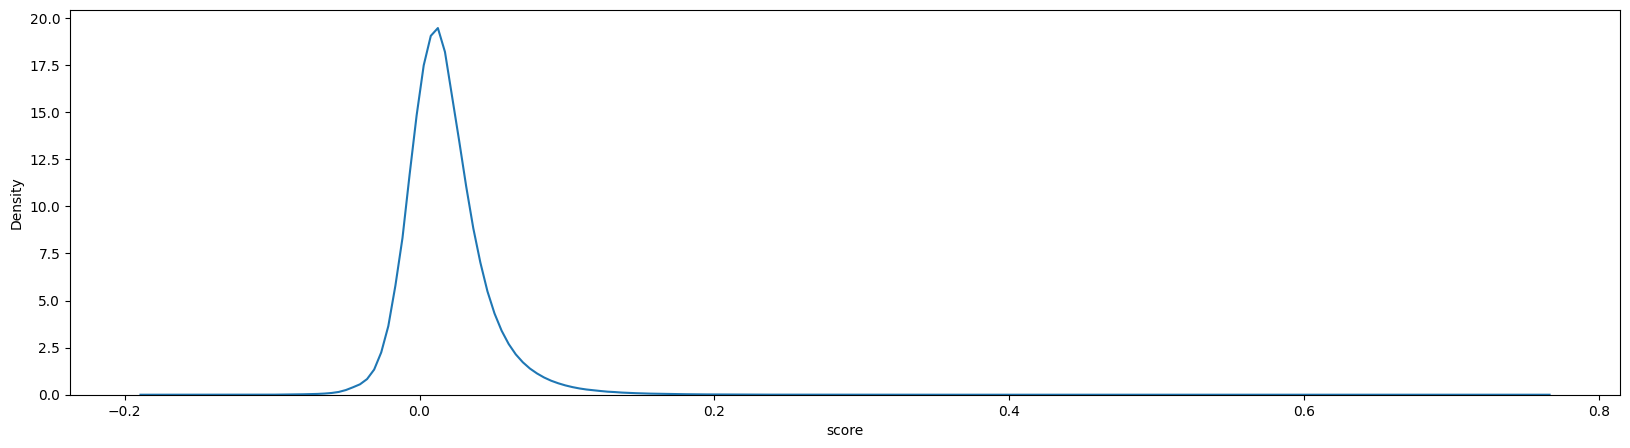

In [5]:
from matplotlib import pyplot as plt
import seaborn as sns


plt.figure(figsize=(20,5))

sns.kdeplot(data=overlappingDf, x='score')

plt.show()

### Attribution score distribution (Zoomed)

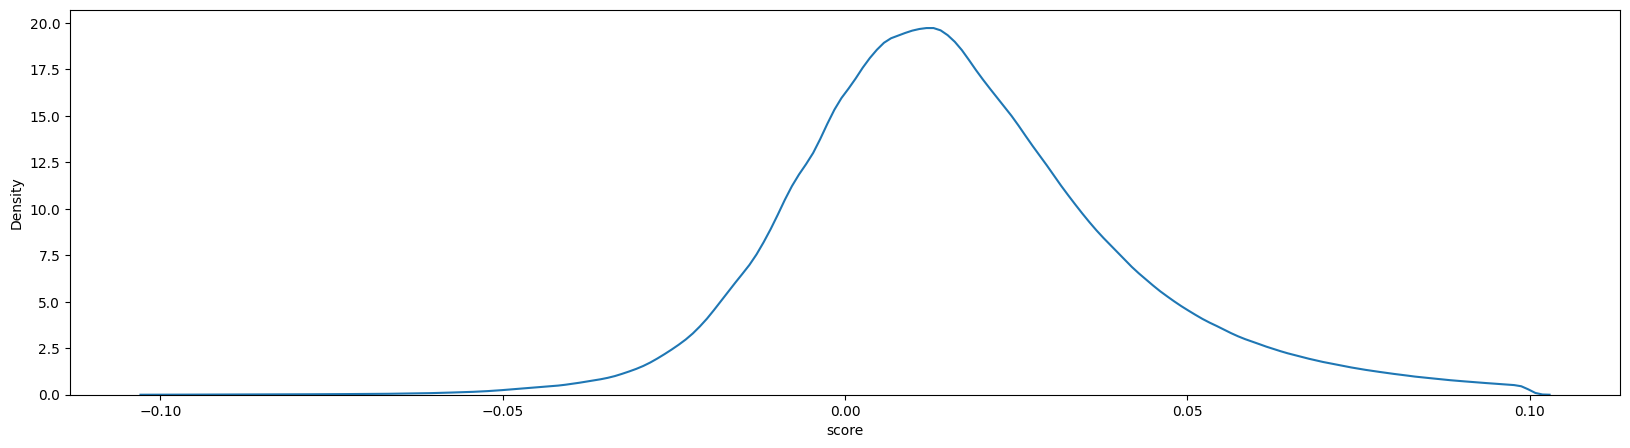

In [6]:
from matplotlib import pyplot as plt
import seaborn as sns


plt.figure(figsize=(20,5))

sns.kdeplot(data=overlappingDf[(overlappingDf.score > -0.1) & (overlappingDf.score < 0.1)], x='score')

plt.show()

### High attribution score

In [7]:
cutoff = overlappingDf.score.mean() + 0 * overlappingDf.score.std()
cutoff

np.float64(0.017727971925421228)

In [8]:
from scipy import stats

highScoreOverlappingDf = overlappingDf[(overlappingDf.score > cutoff)].tokens.value_counts().reset_index()
lowScoreOverlappingDf = overlappingDf[(overlappingDf.score < cutoff)].tokens.value_counts().reset_index()
mergedOverlappingDf = highScoreOverlappingDf.add_suffix('_hs').merge(
    lowScoreOverlappingDf.add_suffix('_ls'),
    how='inner',
    left_on=['tokens_hs'],
    right_on=['tokens_ls']
)[['tokens_hs', 'count_hs', 'count_ls']].rename(columns={'tokens_hs': 'tokens'})

mergedOverlappingDf['proportion_ls'] = mergedOverlappingDf.count_ls/mergedOverlappingDf.count_ls.sum()

mergedOverlappingDf['count_expected'] = mergedOverlappingDf.proportion_ls * mergedOverlappingDf.count_hs.sum()

filteredOverlappingDf = mergedOverlappingDf[(mergedOverlappingDf.count_hs >= 5) & (mergedOverlappingDf.count_ls >= 5)]

chi2, p, dof, expected = stats.chi2_contingency(pd.crosstab(filteredOverlappingDf.count_hs, filteredOverlappingDf.count_expected), correction=True)
significant = p < 0.05  # 5% significance level
print(chi2, p, significant)


2929976.4191109077 0.0 True


`The chi-square test indicates that the tokens associated with the high score group are significantly different than the rest`

#### Calculate the ratio of count differences

In [9]:
filteredOverlappingDf.loc[:, 'ratio_difference'] = (filteredOverlappingDf.count_hs / filteredOverlappingDf.count_expected)
filteredOverlappingDf

/tmp/ipykernel_22385/2481632118.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filteredOverlappingDf.loc[:, 'ratio_difference'] = (filteredOverlappingDf.count_hs / filteredOverlappingDf.count_expected)


,tokens,count_hs,count_ls,proportion_ls,count_expected,ratio_difference
0,CAGCAG,6506,54,0.000015,36.472425,178.381339
1,TTTCAG,5092,285,0.000078,192.493354,26.452861
2,CTGGTG,4232,131,0.000036,88.479402,47.830342
3,GCTGAA,4194,33,0.000009,22.288704,188.167063
4,CATCGC,4187,37,0.000010,24.990365,167.544570
...,...,...,...,...,...,...
18613,GGGATATTTC,5,72,0.000020,48.629900,0.102817
18614,TGCTTAACC,5,99,0.000027,66.866113,0.074776
18615,CGGCGAT,5,198,0.000054,133.732225,0.037388
18616,ACCTCGGTA,5,100,0.000027,67.541528,0.074029


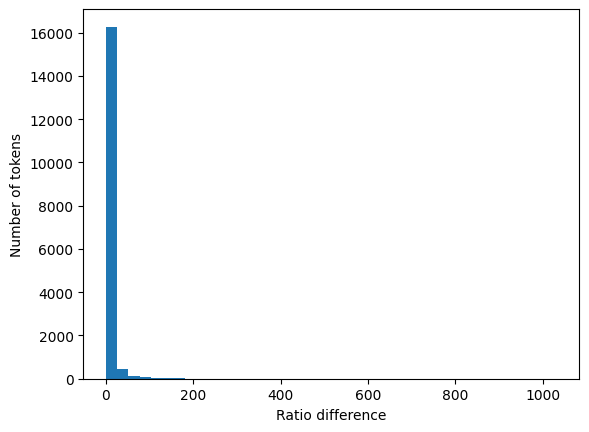

In [10]:
import numpy as np
from matplotlib import pyplot as plt


plt.hist(filteredOverlappingDf.ratio_difference, bins=40)
plt.xlabel("Ratio difference")
plt.ylabel("Number of tokens")
plt.show()

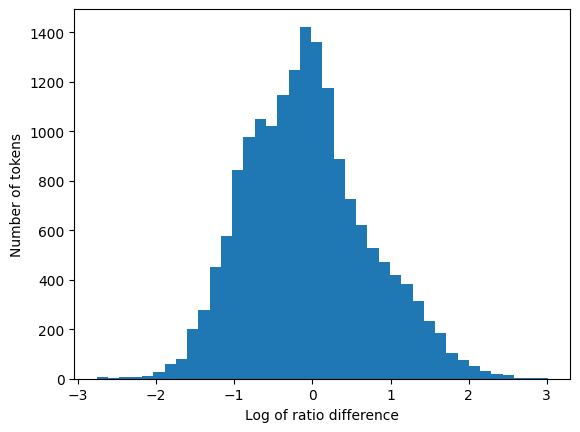

In [11]:
import numpy as np
from matplotlib import pyplot as plt


plt.hist(filteredOverlappingDf.ratio_difference.apply(np.log10), bins=40)
plt.xlabel("Log of ratio difference")
plt.ylabel("Number of tokens")
plt.show()

#### Over represented tokens associated with the high attribution score

In [16]:
overrepresentedTokensDf = filteredOverlappingDf.sort_values(by=['ratio_difference'])[filteredOverlappingDf.ratio_difference > 400]
overrepresentedTokensDf

/tmp/ipykernel_22385/1177317081.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  overrepresentedTokensDf = filteredOverlappingDf.sort_values(by=['ratio_difference'])[filteredOverlappingDf.ratio_difference > 400]


,tokens,count_hs,count_ls,proportion_ls,count_expected,ratio_difference
87,GGTTT,1897,6,0.000002,4.052492,468.107069
50,CGTCTGG,2239,6,0.000002,4.052492,552.499593
90,CGTACC,1880,5,0.000001,3.377076,556.694543
9,CAGTT,3717,9,0.000002,6.078738,611.475655
13,AAACAG,3484,5,0.000001,3.377076,1031.661589


#### Over represented genes associated with the high attribution score

In [17]:
tempDf = overrepresentedTokensDf.merge(overlappingDf[['tokens', 'feature_type', 'id', 'name', 'gene']], how='inner', on=['tokens'])

tempDf[['tokens', 'feature_type', 'gene', 'name']].groupby(by=['feature_type', 'gene', 'name']).agg('count').reset_index().sort_values(by=['tokens'], ascending=False)[:15]

,feature_type,gene,name,tokens
1171,CDS,sppa,signal peptide peptidase SppA,48
488,CDS,glcb,malate synthase G,46
542,CDS,gsta,glutathione transferase GstA,46
221,CDS,cydc,cysteine/glutathione ABC transporter ATP-bindi...,46
817,CDS,nage,PTS N-acetyl glucosamine transporter subunit I...,45
1572,CDS,yfas,Putative alpha-2-macroglobulin-like protein,45
1398,CDS,ybgi,radiation resistance protein YbgI,43
1578,CDS,yfbs,Uncharacterized transporter YfbS,41
130,CDS,btss,two-component regulatory system sensor histidi...,40
1307,CDS,uxac,glucuronate isomerase,40


#### Under represented tokens associated with the high attribution score

In [20]:
underrepresentedTokensDf = filteredOverlappingDf.sort_values(by=['ratio_difference'])[filteredOverlappingDf.ratio_difference < 0.005]
underrepresentedTokensDf

/tmp/ipykernel_22385/103659661.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  underrepresentedTokensDf = filteredOverlappingDf.sort_values(by=['ratio_difference'])[filteredOverlappingDf.ratio_difference < 0.005]


,tokens,count_hs,count_ls,proportion_ls,count_expected,ratio_difference
18403,AACGCC,5,4230,0.001161,2857.006629,0.001750
17217,GAAGTG,8,6046,0.001659,4083.560775,0.001959
17799,ATCGAC,7,4670,0.001281,3154.189352,0.002219
18414,GTCGC,5,3315,0.000910,2239.001649,0.002233
18311,TTCCCG,5,3106,0.000852,2097.839856,0.002383
16807,GATATC,10,5362,0.001471,3621.576725,0.002761
17614,AACGT,7,3086,0.000847,2084.331550,0.003358
18218,CAGCTT,5,2094,0.000575,1414.319594,0.003535
15425,ATCGCC,15,5845,0.001604,3947.802304,0.003800
16612,ATAAA,10,3860,0.001059,2607.102976,0.003836


#### Under represented genes associated with the high attribution score

In [20]:
tempDf = underrepresentedTokensDf.merge(overlappingDf[['tokens', 'feature_type', 'id', 'name', 'gene']], how='inner', on=['tokens'])

tempDf[['tokens', 'feature_type', 'gene', 'name']].groupby(by=['feature_type', 'gene', 'name']).agg('count').reset_index().sort_values(by=['tokens'], ascending=False)[:15]
# gene.value_counts().reset_index()[:5]

,feature_type,gene,name,tokens
1041,CDS,gltb,glutamate synthase large subunit,316
3495,CDS,yhdp,AsmA2 domain-containing protein YhdP,265
653,CDS,ebga,beta-galactosidase subunit alpha,214
1322,CDS,irp1,yersiniabactin biosynthetic protein Irp1,198
2194,CDS,rcsd,phosphotransferase RcsD,195
1669,CDS,mukb,chromosome partition protein MukB,188
700,CDS,entf,enterobactin synthase multienzyme complex comp...,175
2488,CDS,ssle,lipoprotein metalloprotease SslE,170
386,CDS,clpa,ATP-dependent Clp protease ATP-binding subunit...,163
2042,CDS,ppsa,phosphoenolpyruvate synthase,158


### Low attribution score

In [21]:
cutoff = overlappingDf.score.mean() - 0 * overlappingDf.score.std()
cutoff

np.float64(0.017727971925421228)

In [22]:
from scipy import stats


highScoreOverlappingDf = overlappingDf[(overlappingDf.score > cutoff)].tokens.value_counts().reset_index()
lowScoreOverlappingDf = overlappingDf[(overlappingDf.score < cutoff)].tokens.value_counts().reset_index()
mergedOverlappingDf = highScoreOverlappingDf.add_suffix('_hs').merge(
    lowScoreOverlappingDf.add_suffix('_ls'),
    how='inner',
    left_on=['tokens_hs'],
    right_on=['tokens_ls']
)[['tokens_hs', 'count_hs', 'count_ls']].rename(columns={'tokens_hs': 'tokens'})

mergedOverlappingDf['proportion_ls'] = mergedOverlappingDf.count_ls/mergedOverlappingDf.count_ls.sum()

mergedOverlappingDf['count_expected'] = mergedOverlappingDf.proportion_ls * mergedOverlappingDf.count_hs.sum()

filteredOverlappingDf = mergedOverlappingDf[(mergedOverlappingDf.count_hs >= 5) & (mergedOverlappingDf.count_ls >= 5)]

chi2, p, dof, expected = stats.chi2_contingency(pd.crosstab(filteredOverlappingDf.count_hs, filteredOverlappingDf.count_expected), correction=True)
significant = p < 0.05  # 5% significance level
print(chi2, p, significant)


2929976.4191109077 0.0 True


#### Calculate the ratio of count differences

In [23]:
filteredOverlappingDf.loc[:, 'ratio_difference'] = (filteredOverlappingDf.count_hs / filteredOverlappingDf.count_expected)

/tmp/ipykernel_22385/3361415802.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filteredOverlappingDf.loc[:, 'ratio_difference'] = (filteredOverlappingDf.count_hs / filteredOverlappingDf.count_expected)


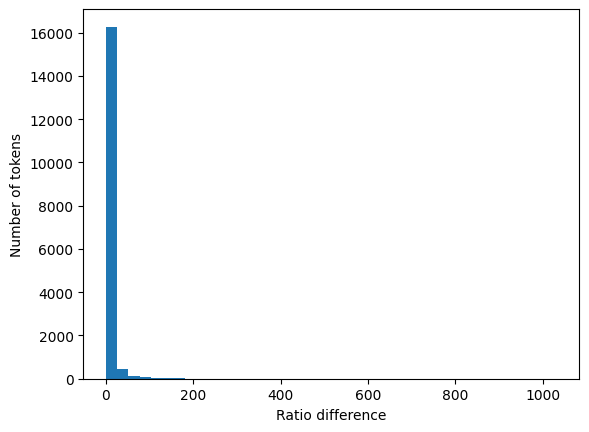

In [24]:
import numpy as np
from matplotlib import pyplot as plt


plt.hist(filteredOverlappingDf.ratio_difference, bins=40)
plt.xlabel("Ratio difference")
plt.ylabel("Number of tokens")
plt.show()

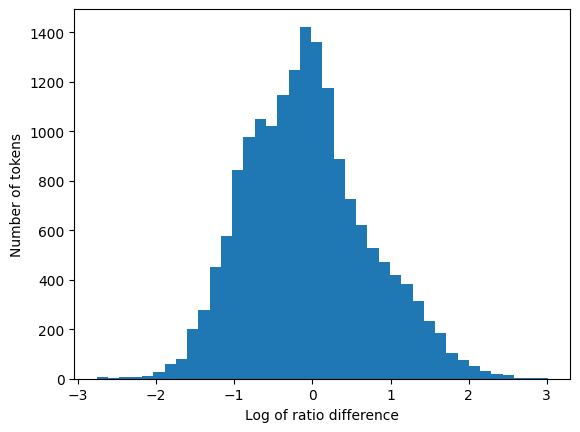

In [25]:
import numpy as np
from matplotlib import pyplot as plt


plt.hist(filteredOverlappingDf.ratio_difference.apply(np.log10), bins=40)
plt.xlabel("Log of ratio difference")
plt.ylabel("Number of tokens")
plt.show()

#### Over represented tokens associated with the low attribution score

In [32]:
overrepresentedTokensDf = filteredOverlappingDf.sort_values(by=['ratio_difference'])[filteredOverlappingDf.ratio_difference > 500]
overrepresentedTokensDf

/tmp/ipykernel_22385/1578575166.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  overrepresentedTokensDf = filteredOverlappingDf.sort_values(by=['ratio_difference'])[filteredOverlappingDf.ratio_difference > 500]


,tokens,count_hs,count_ls,proportion_ls,count_expected,ratio_difference
50,CGTCTGG,2239,6,0.000002,4.052492,552.499593
90,CGTACC,1880,5,0.000001,3.377076,556.694543
9,CAGTT,3717,9,0.000002,6.078738,611.475655
13,AAACAG,3484,5,0.000001,3.377076,1031.661589


#### Over represented genes associated with the low attribution score

In [27]:
tempDf = overrepresentedTokensDf.merge(overlappingDf[['tokens', 'feature_type', 'id', 'name', 'gene']], how='inner', on=['tokens'])

tempDf[['tokens', 'feature_type', 'gene', 'name']].groupby(by=['feature_type', 'gene', 'name']).agg('count').reset_index().sort_values(by=['tokens'], ascending=False)[:15]

,feature_type,gene,name,tokens
1790,CDS,mukb,chromosome partition protein MukB,320
1005,CDS,ftsk,DNA translocase FtsK,312
1409,CDS,irp1,yersiniabactin biosynthetic protein Irp1,307
1108,CDS,gltb,glutamate synthase large subunit,280
2661,CDS,ssle,lipoprotein metalloprotease SslE,277
3739,CDS,yhdp,AsmA2 domain-containing protein YhdP,258
1089,CDS,glne,bifunctional [glutamate--ammonia ligase]-adeny...,246
3407,CDS,ydij,D-2-hydroxyglutarate dehydrogenase,246
747,CDS,entf,enterobactin synthase multienzyme complex comp...,239
590,CDS,dgce,diguanylate cyclase,237


#### Under represented tokens associated with the low attribution score

In [31]:
underrepresentedTokensDf = filteredOverlappingDf.sort_values(by=['ratio_difference'])[filteredOverlappingDf.ratio_difference < 0.005]
underrepresentedTokensDf

/tmp/ipykernel_22385/103659661.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  underrepresentedTokensDf = filteredOverlappingDf.sort_values(by=['ratio_difference'])[filteredOverlappingDf.ratio_difference < 0.005]


,tokens,count_hs,count_ls,proportion_ls,count_expected,ratio_difference
18403,AACGCC,5,4230,0.001161,2857.006629,0.001750
17217,GAAGTG,8,6046,0.001659,4083.560775,0.001959
17799,ATCGAC,7,4670,0.001281,3154.189352,0.002219
18414,GTCGC,5,3315,0.000910,2239.001649,0.002233
18311,TTCCCG,5,3106,0.000852,2097.839856,0.002383
16807,GATATC,10,5362,0.001471,3621.576725,0.002761
17614,AACGT,7,3086,0.000847,2084.331550,0.003358
18218,CAGCTT,5,2094,0.000575,1414.319594,0.003535
15425,ATCGCC,15,5845,0.001604,3947.802304,0.003800
16612,ATAAA,10,3860,0.001059,2607.102976,0.003836


#### Under represented genes associated with the low attribution score

In [29]:
tempDf = underrepresentedTokensDf.merge(overlappingDf[['tokens', 'feature_type', 'id', 'name', 'gene']], how='inner', on=['tokens'])

tempDf[['tokens', 'feature_type', 'gene', 'name']].groupby(by=['feature_type', 'gene', 'name']).agg('count').reset_index().sort_values(by=['tokens'], ascending=False)[:15]

,feature_type,gene,name,tokens
1041,CDS,gltb,glutamate synthase large subunit,316
3495,CDS,yhdp,AsmA2 domain-containing protein YhdP,265
653,CDS,ebga,beta-galactosidase subunit alpha,214
1322,CDS,irp1,yersiniabactin biosynthetic protein Irp1,198
2194,CDS,rcsd,phosphotransferase RcsD,195
1669,CDS,mukb,chromosome partition protein MukB,188
700,CDS,entf,enterobactin synthase multienzyme complex comp...,175
2488,CDS,ssle,lipoprotein metalloprotease SslE,170
386,CDS,clpa,ATP-dependent Clp protease ATP-binding subunit...,163
2042,CDS,ppsa,phosphoenolpyruvate synthase,158
